In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [2]:
##For this churn problem - the data is being loaded from https://www.kaggle.com/blastchar/telco-customer-churn

file = '../WA_Fn-UseC_-Telco-Customer-Churn.csv'

churn_data = pd.read_csv(file)

In [3]:
churn_data.columns = [col.title() for col in churn_data.columns]

In [4]:
churn_data.columns

Index(['Customerid', 'Gender', 'Seniorcitizen', 'Partner', 'Dependents',
       'Tenure', 'Phoneservice', 'Multiplelines', 'Internetservice',
       'Onlinesecurity', 'Onlinebackup', 'Deviceprotection', 'Techsupport',
       'Streamingtv', 'Streamingmovies', 'Contract', 'Paperlessbilling',
       'Paymentmethod', 'Monthlycharges', 'Totalcharges', 'Churn'],
      dtype='object')

Our baseline is going to be randomly assigning a class - 0/1 for No churn/Churn respectively

I am selecting three models here - linear regression for its class probability estimations, knn as it based on distances and a tree based random forest model for its information gain with features. We can later make ensemble models combining them.

In [5]:
churn_data.dtypes

Customerid           object
Gender               object
Seniorcitizen         int64
Partner              object
Dependents           object
Tenure                int64
Phoneservice         object
Multiplelines        object
Internetservice      object
Onlinesecurity       object
Onlinebackup         object
Deviceprotection     object
Techsupport          object
Streamingtv          object
Streamingmovies      object
Contract             object
Paperlessbilling     object
Paymentmethod        object
Monthlycharges      float64
Totalcharges         object
Churn                object
dtype: object

In [6]:
#reengineering some features to reduce the distance issues with some classification models.
churn_data['Tenure_in_yrs'] = churn_data['Tenure']//12
churn_data['Monthlycharges_100s'] = round(churn_data['Monthlycharges']/100,2)
churn_data['Totalcharges'] = pd.to_numeric(churn_data['Totalcharges'], errors='coerce').fillna(0)
churn_data['Totalcharges_1000s'] = round(churn_data['Totalcharges']/1000, 2)

In [8]:
#replace 'No Internet Service' and 'No Phone Service'  as No
churn_data = churn_data.replace({'No phone service':'No', 'No internet service':'No'})

In [9]:
churn_data.dtypes

Customerid              object
Gender                  object
Seniorcitizen            int64
Partner                 object
Dependents              object
Tenure                   int64
Phoneservice            object
Multiplelines           object
Internetservice         object
Onlinesecurity          object
Onlinebackup            object
Deviceprotection        object
Techsupport             object
Streamingtv             object
Streamingmovies         object
Contract                object
Paperlessbilling        object
Paymentmethod           object
Monthlycharges         float64
Totalcharges           float64
Churn                   object
Tenure_in_yrs            int64
Monthlycharges_100s    float64
Totalcharges_1000s     float64
dtype: object

In [10]:
def transform_categorical_data(df, cols, drop_orgnl = True, drop_first=True, convert_ascat = True):
    """
    Transform categorical data in the columns into dummy data using pandas.
    ----------
    df : Dataframe 
    cols : categorical columns to be converted into dummy data
    drop_orgnl : Boolean, if set to True drops the original column.
    drop_first : Boolean if True drops one of the dummy column
    convert_ascat : convert columns into categorical.
    
    Return
    -------
    Dataframe with the original frame concatenated with dummy data
    """

    if convert_ascat == True:
        df[cols] = df[cols].astype('category')
    
    dummy_data = pd.get_dummies(df[cols],prefix=cols,drop_first=drop_first)
    #concatenate the dummy data and dataframe. Drop the original columns 
    
    df_cat = pd.concat([df,dummy_data],axis=1)
    if drop_orgnl == True:
        df_cat.drop(columns=cols, inplace = True)
    
    return df_cat

In [19]:
#taking all the columns except for the customer id
cat_cols = [col for col in churn_data.columns[1:] if (churn_data[col].dtype.name in ['object','category'])]

churn_data_tf = transform_categorical_data(churn_data, cat_cols)

In [20]:
churn_data_tf.columns

Index(['Customerid', 'Seniorcitizen', 'Tenure', 'Monthlycharges',
       'Totalcharges', 'Tenure_in_yrs', 'Monthlycharges_100s',
       'Totalcharges_1000s', 'Gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'Phoneservice_Yes', 'Multiplelines_Yes', 'Internetservice_Fiber optic',
       'Internetservice_No', 'Onlinesecurity_Yes', 'Onlinebackup_Yes',
       'Deviceprotection_Yes', 'Techsupport_Yes', 'Streamingtv_Yes',
       'Streamingmovies_Yes', 'Contract_One year', 'Contract_Two year',
       'Paperlessbilling_Yes', 'Paymentmethod_Credit card (automatic)',
       'Paymentmethod_Electronic check', 'Paymentmethod_Mailed check',
       'Churn_Yes'],
      dtype='object')

In [22]:
#let remove Tenure , Monthlycharges and Totalcharges
churn_data_tf.drop(columns=['Tenure','Monthlycharges','Totalcharges'],inplace=True)

In [25]:
X, Y = churn_data_tf.iloc[:, 1:-1], churn_data_tf.Churn_Yes

In [29]:
#creating a baseline predictor that randomly assigns a customer as churn or no churn
def baseline_pred(X, y_true):
    from numpy.random import rand, randint
    y_pred = [randint(0,2) for i in range(X.shape[0])]
   
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = round(tp/X.shape[0],3)
    print('baseline accuracy is {}'.format(accuracy))    

baseline_pred(X, Y)

baseline accuracy is 0.129


In [30]:
#defining the metrics we want to use to compare for each model
def classification_metrics(y_true, y_pred, model, y_prob, ret_results = True, print_res = True):
    """
    Calculates different classification metrics for the model, and prints out the results
    ----------
    y_true : actual output values 
    y_pred : predicted values based on the model
    model : Classification model with already training data fitted on the model
    ret_results : To return different metrics as a dictionary
    print_res : prints out the metrics as well as roc curve.
    
    Return
    -------
    Returns a dictionary with different metrics if ret_results is set to True
    """
    import matplotlib.pyplot as plt
    
    #balanced accuracy score
    from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, roc_curve, auc
    acc = round(accuracy_score(y_true, y_pred),3)
    bal_acc = round(balanced_accuracy_score(y_true, y_pred),3)
    #sensitivity and specificity - identifiying churning customers more important than stable customers
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(tp/(tp+fn), 3)
    specificity = round(tn/(tn+fp), 3)
    
    #auc score
    fpr, tpr, thresholds = roc_curve(y_true, y_prob[:,1])
    auc_score = round(auc(fpr, tpr), 3)
    res_dict = {'Accuracy':acc, 'Balanced acc':bal_acc, 'sensitivity': sensitivity, 
                'specificity':specificity, 'auc':auc_score}
    
    if print_res == True:
        print(model)
        print(res_dict)
        
        plt.grid()
        plt.plot(fpr,tpr)
        plt.fill_between(fpr, tpr, color = 'silver')
        plt.annotate('Area under Curve {}'.format(auc_score), (0,0.9), fontsize = 10)
        plt.title('ROC Curve')
        plt.show()
    
    if ret_results == True:
        return res_dict


In [36]:
# need to generalize this function with any model and its additional parameters


def model_CVsplit_metrics(X, Y, model, size = 0.4, random_st = 16):
    """
    Fits the classification model with a train test split and calculates and displays the metrics
    ----------
    X : input data set 
    Y : output labels 
    model : Classification model with parameters tuned.
    size : Size of the test for the train_test_split
    random_st : random state value
    
    Return
    -------
    Returns the model with fitted data
    """
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=size, random_state = random_st)
    
    model = model.fit(X_train,y_train)
    
    test_score = model.score(X_test, y_test)
    train_score = model.score(X_train, y_train)
       
    print('test score {0:.3g}'.format(test_score))
    print('training score {0:.3g}'.format(train_score))
    
    y_hat = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    classification_metrics(y_true = y_test, y_pred=y_hat, model=model, y_prob=y_proba, ret_results= False)
    return model

test score 0.796
training score 0.805
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
{'Accuracy': 0.796, 'Balanced acc': 0.716, 'sensitivity': 0.548, 'specificity': 0.883, 'auc': 0.84}


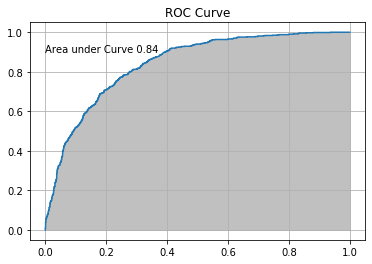

In [37]:
#applying logistic regression
logit = LogisticRegression(solver='liblinear')
logit = model_CVsplit_metrics(X, Y, model= logit)

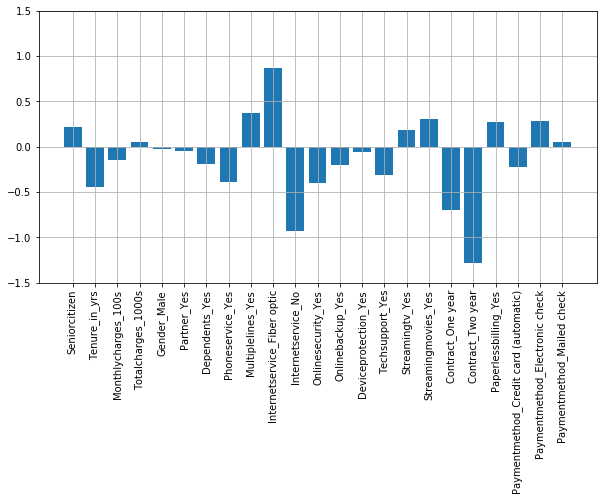

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(x = X.columns, height=logit.coef_[0])
plt.xticks(rotation=90)
plt.ylim(-1.5,1.5)
plt.grid()
plt.show()

test score 0.763
training score 0.99
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
{'Accuracy': 0.763, 'Balanced acc': 0.687, 'sensitivity': 0.528, 'specificity': 0.846, 'auc': 0.773}


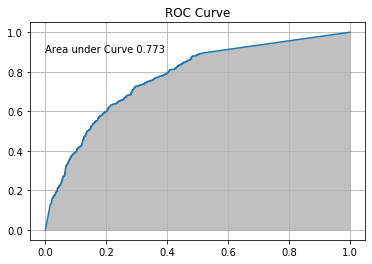

In [38]:
knn_model = KNeighborsClassifier(weights='distance')
knn_model = model_CVsplit_metrics(X,Y, knn_model)

test score 0.79
training score 0.99
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'Accuracy': 0.79, 'Balanced acc': 0.698, 'sensitivity': 0.506, 'specificity': 0.89, 'auc': 0.819}


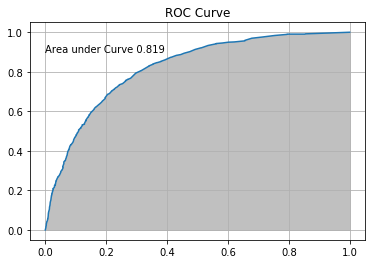

In [41]:
rnd_forest = RandomForestClassifier(n_estimators=100)
rnd_forest = model_CVsplit_metrics(X,Y,rnd_forest)

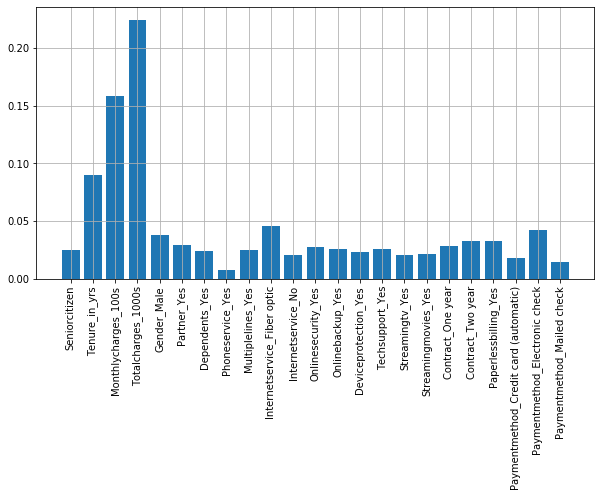

In [68]:
plt.figure(figsize=(10,5))
plt.bar(x = X.columns, height=rnd_forest.feature_importances_)
plt.xticks(rotation=90)
plt.grid()
plt.show()
